In [1]:
from kafka import KafkaConsumer, KafkaProducer
import json
import math
import plotly
import plotly.plotly as py
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot_mpl, iplot, plot
import plotly.graph_objs as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf
from sklearn.model_selection import train_test_split
import pandas as pd
from pmdarima import auto_arima
from pmdarima.arima import ADFTest,ARIMA, CHTest
from pmdarima.utils import c, diff
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from collections import defaultdict
import json
import logging
import itertools
import pickle

In [39]:
consumer = KafkaConsumer(
    "collectd",
    group_id='arima3',
    auto_offset_reset="earliest",
    enable_auto_commit=True,
    bootstrap_servers=["152.46.17.159:9092"],
    consumer_timeout_ms=10000,
    )

In [40]:
memory_redis = []
time_stamp = []
memory_host = defaultdict(list)
timestamp_host = defaultdict(list)


In [ ]:
for msg in consumer:
        value = msg.value
        result = json.loads(value.decode("utf8"))
        if result[0]["type"] == "memory" and result[0]["plugin"] == "redis": # and  result[0]["type_instance"] == "used":
            if result[0]["values"][0]:
                if not math.isnan(float(result[0]["values"][0])):
                    print(result[0]["host"])
                    print(result[0]["values"][0])
                    try:
                        memory_host[result[0]["host"]].append(result[0]["values"][0])
                        timestamp_host[result[0]["host"]].append(result[0]["time"])
                    except Exception as e:
                        logging.error(e)
                        continue
consumer.close()


In [ ]:
max_length=0
max_length_host=0
for hosts in memory_host.keys():
    print(memory_host[hosts])
    if(len(memory_host[hosts])>max_length):
        max_length=len(memory_host[hosts])
        max_length_host=hosts

for values in itertools.zip_longest(*memory_host.values(),fillvalue=0):
    memory_redis.append(sum(values)/1024)
for values in timestamp_host[max_length_host]:
    time_stamp.append(values)
    

In [ ]:
df = pd.DataFrame()
df["time_stamp"] = time_stamp
df["time_stamp"] = pd.to_datetime(df["time_stamp"], unit='s', utc=True)
df["memory_used"] = memory_redis
x = pd.Series(df["memory_used"])
df.set_index("time_stamp",inplace=True)

In [32]:
trace = go.Scatter(
        x=df.index, 
        y=df["memory_used"],
        mode = 'lines+markers'
    )
data = [trace]

In [33]:
try:
    forecast_in = open("forecast.pickle","rb")
    future_forecast = pickle.load(forecast_in)
    forecast_in.append(df)
    error=0
    if len(df) < len(future_forecast):
        error=mean_absolute_error(df, future_forecast[:len(df)])
    elif len(df) > len(future_forecast):
        error=mean_absolute_error(df[0:len(future_forecast)], future_forecast)
    else:
        error=mean_absolute_error(df, future_forecast)
    logging.info("Mean Absolute Error in Last iteration ".join(error))
except Exception as e:
    print(e)
    # Do Nothing

'_io.BufferedReader' object has no attribute 'append'


/home/akshay/.local/lib/python3.5/site-packages/plotly/offline/offline.py:654: UserWarning:

Your filename `memory-used-overtime` didn't end with .html. Adding .html to the end of your file.



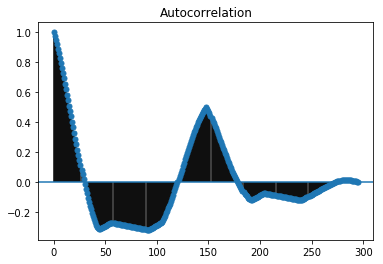

In [34]:
plot(data, filename="memory-used-overtime")
#pm.plot_pacf(df,show=True)#.savefig('pacf.png')
pm.plot_acf(df,show=True)#.savefig('acf.png')

In [35]:
try:
    pickle_in = open("arima.pickle","rb")
    arima_data = pickle.load(pickle_in)
    arima_data.append(df)
    # df=arima_data
except:
    arima_data_out = open("arima.pickle","wb")    
    pickle.dump([], arima_data_out)
arima_data_out = open("arima.pickle","wb")
pickle.dump(df, arima_data_out)
arima_data_out.close()

In [36]:
nd=0
nsd=0
try:
    adf_test=ADFTest(alpha=0.05)
    p_val, should_diff = adf_test.is_stationary(df["memory_used"])    

    nd = ndiffs(df, test='adf')
    print(nd)
    nsd = nsdiffs(df,12)
    print(nsd)
except Exception as e:
    print(e)
    print("Exception on tests")

ch_test=CHTest(12)
try:
    ch_test=ch_test.estimate_seasonal_differencing_term(df)
except Exception as e:
    logging.error(e)
        

1
0


In [38]:
p=3
q=1
d=1

train, test = train_test_split(df,shuffle=False, test_size=0.3)

stepwise_model = ARIMA(
    order=(p,d,q),
    seasonal_order=(0,1,0,12),
    suppress_warnings=True, 
    scoring='mse'
)
x=str(p)+" "+str(d)+" "+str(q)
print(x)

stepwise_model.fit(df)
future_forecast = stepwise_model.predict(n_periods=len(test))
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=["prediction"])
# logging.info(mean_absolute_error(test, future_forecast))
res=pd.concat([df,future_forecast],axis=1)

'''
    Save Forecast in Pickle 
'''
forecast_out = open("forecast.pickle","wb")
pickle.dump(future_forecast,forecast_out)
forecast_out.close()

3 1 1


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
trace1 = go.Scatter(x=res.index, y=res["prediction"],name="Prediction", mode='lines')
trace2 = go.Scatter(x=df.index, y=df["memory_used"],name="DF data", mode='lines')
data=[trace1,trace2]
layout = go.Layout(
    title=x
)
fig = go.Figure(data=data, layout=layout)
plot(fig, filename="prediction")

In [ ]:
print(df)
print(future_forecast)